In [57]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon.data import DataLoader, ArrayDataset
import matplotlib.pyplot as plt

data_path = "./dataset/adults/train"
test_path = "./dataset/adults/test"
    

In [58]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

data_raw = ""
#open the data files 
with(open(data_path)) as file:
    data_raw = file.read()
with open(test_path) as file:
    test_raw = file.read()



In [59]:
def process_data(raw_data):
    train_lines = raw_data.splitlines()
    num_examples = len(train_lines)
    num_features = 123
    X = nd.zeros((num_examples, num_features), ctx=data_ctx)
    Y = nd.zeros((num_examples, 1), ctx=data_ctx)
    for i, line in enumerate(train_lines):
        tokens = line.split()
        label = (int(tokens[0]) + 1) / 2  # Change label from {-1,1} to {0,1}
        Y[i] = label
        for token in tokens[1:]:
            index = int(token[:-2]) - 1
            X[i, index] = 1
    return X, Y

In [60]:
#Process the train and test dataset and convert to nd instances
X_train, Y_train = process_data(data_raw)
X_test, Y_test = process_data(test_raw)


In [61]:
print("SHAPE: " )
print(X_train.shape)
print(X_test.shape)

train_dataloader = DataLoader(ArrayDataset(X_train, Y_train), batch_size=64, shuffle=True)
test_dataloader = DataLoader(ArrayDataset(X_test, Y_test), batch_size=64, shuffle=True)

SHAPE: 
(30956, 123)
(1605, 123)
dense5_ (
  Parameter dense5_weight (shape=(1, 0), dtype=float32)
  Parameter dense5_bias (shape=(1,), dtype=float32)
)


In [62]:
#define a sigmoid
def logistic(z):
    return 1. / (1. + nd.exp(-z))
#define a log loss
def log_loss(y_pred, y):
    yhat = logistic(y_pred)
    return -nd.nansum( y * nd.log(yhat) + (1-y)*nd.log(1-yhat))

In [64]:
#Create a net
#Define the model with Dense
net = gluon.nn.Dense(1)
#init params
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)
#create optimizer 
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.01})

print(net.collect_params())

#Train the network 
epochs = 30
batch_size = 64
loss_sequence = []
n_examples = X_train.shape[0]

for e in range(epochs):
    cum_loss = 0
    for i,(data,label)  in enumerate(train_dataloader):
        with autograd.record():
            ypred = net(data)
            loss = log_loss(ypred, label)
        loss.backward()
        trainer.step(batch_size=batch_size)
        cum_loss+= nd.mean(loss).asscalar()
    print("Epoch {}, loss {}".format(e, cum_loss))
    loss_sequence.append(cum_loss)

Epoch 0, loss 12547.784077644348
Epoch 1, loss 12323.209238052368
Epoch 2, loss 12130.995162010193
Epoch 3, loss 11964.380876541138
Epoch 4, loss 11819.014466285706
Epoch 5, loss 11691.038009643555
Epoch 6, loss 11578.832670211792
Epoch 7, loss 11480.044098854065
Epoch 8, loss 11389.015935897827
Epoch 9, loss 11314.771946907043
Epoch 10, loss 11244.522882461548
Epoch 11, loss 11181.466049671173
Epoch 12, loss 11125.084665298462
Epoch 13, loss 11073.754455566406
Epoch 14, loss 11027.240797042847
Epoch 15, loss 10984.512371063232
Epoch 16, loss 10945.69527053833
Epoch 17, loss 10909.373461723328
Epoch 18, loss 10876.305819511414
Epoch 19, loss 10845.181244850159
Epoch 20, loss 10816.766547203064
Epoch 21, loss 10790.028327941895
Epoch 22, loss 10765.214916229248
Epoch 23, loss 10740.748906135559
Epoch 24, loss 10719.197072029114
Epoch 25, loss 10698.292253494263
Epoch 26, loss 10678.476301193237
Epoch 27, loss 10659.539561271667
Epoch 28, loss 10641.305485248566
Epoch 29, loss 10625.3104

Accuracy: 0.827 (1327.0/1605)


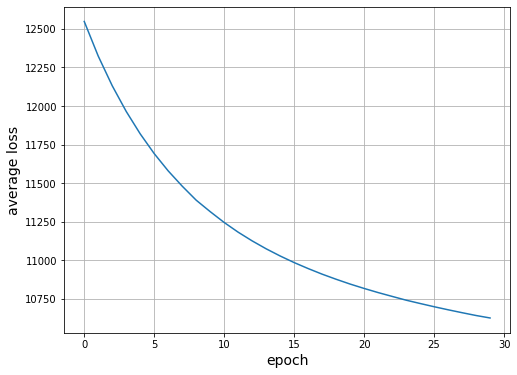

In [67]:
#plot the loss sequence
plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

#Test accuracy

num_correct = 0.0
num_total = X_test.shape[0]

for i,(data,label) in enumerate(test_dataloader):
    output = net(data)
    prediction = (nd.sign(output)+1)/2
    num_correct += nd.sum(prediction == label)
print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))
